# 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/9_chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/9_chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/9_chest_xray/data/test/*/*'


BATCH_SIZE = 32
EPOCHS = 40

print(ROOT_PATH)

/aiffel/aiffel


# 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


# 데이터 전처리

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}') 
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/9_chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/9_chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename]) # 정상적인 폐 이미지 수 카운트
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])# 폐렴 이미지 수 카운트
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):    #train_ds.take(1)은 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### Augmentation : Random Resize / crop, Regularization : BatchNorm, Dropout

In [14]:
input_shape = [180, 180, 3]

def augment(image,label):
    # random resize and random crop back to expected size
    random_scale_factor = tf.random.uniform([1], minval=1., maxval=1.4, dtype=tf.float32)
    scaled_height = tf.cast(tf.cast(input_shape[0], tf.float32) * random_scale_factor, tf.int32)
    scaled_width = tf.cast(tf.cast(input_shape[1], tf.float32) * random_scale_factor, tf.int32)       
    scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))

    image = tf.image.resize(image, scaled_shape)
    image = tf.image.random_crop(image, input_shape)
    
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 시각화

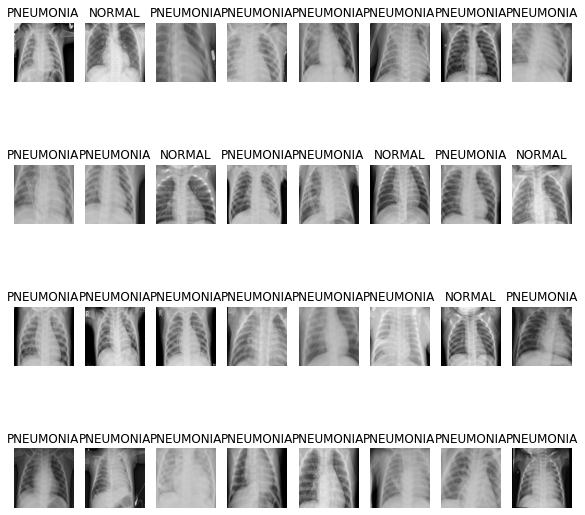

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 데이터 imbalance 처리

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 모델 훈련

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
130/130 [==============================] - 61s 372ms/step - loss: 0.5913 - accuracy: 0.6904 - precision: 0.9070 - recall: 0.6512 - val_loss: 0.5955 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 2/40
130/130 [==============================] - 49s 376ms/step - loss: 0.3435 - accuracy: 0.8541 - precision: 0.9596 - recall: 0.8386 - val_loss: 0.6850 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 3/40
130/130 [==============================] - 50s 385ms/step - loss: 0.2790 - accuracy: 0.8820 - precision: 0.9637 - recall: 0.8745 - val_loss: 1.2203 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/40
130/130 [==============================] - 51s 392ms/step - loss: 0.2528 - accuracy: 0.8933 - precision: 0.9672 - recall: 0.8864 - val_loss: 1.7144 - val_accuracy: 0.7393 - val_precision: 0.7393 - val_recall: 1.0000
Epoch 5/40
130/130 [==============================] - 53s 410ms/step - loss: 0.2438 - accura

Epoch 37/40
130/130 [==============================] - 46s 357ms/step - loss: 0.1073 - accuracy: 0.9591 - precision: 0.9880 - recall: 0.9566 - val_loss: 0.1013 - val_accuracy: 0.9639 - val_precision: 0.9799 - val_recall: 0.9708
Epoch 38/40
130/130 [==============================] - 45s 350ms/step - loss: 0.1101 - accuracy: 0.9589 - precision: 0.9873 - recall: 0.9569 - val_loss: 0.1047 - val_accuracy: 0.9609 - val_precision: 0.9520 - val_recall: 0.9974
Epoch 39/40
130/130 [==============================] - 45s 349ms/step - loss: 0.1131 - accuracy: 0.9519 - precision: 0.9853 - recall: 0.9497 - val_loss: 0.1142 - val_accuracy: 0.9570 - val_precision: 0.9890 - val_recall: 0.9522
Epoch 40/40
130/130 [==============================] - 44s 343ms/step - loss: 0.1059 - accuracy: 0.9555 - precision: 0.9879 - recall: 0.9518 - val_loss: 0.1118 - val_accuracy: 0.9541 - val_precision: 0.9784 - val_recall: 0.9590


# 결과 확인

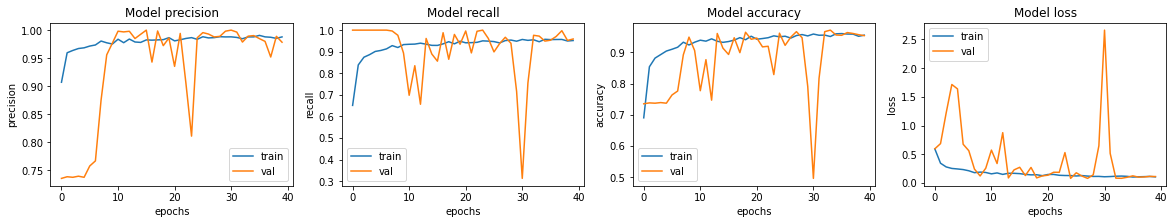

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 223ms/step - loss: 0.2746 - accuracy: 0.8926 - precision: 0.8713 - recall: 0.9718
Loss: 0.2745654284954071,
Accuracy: 0.8926281929016113,
Precision: 0.8712643384933472,
Recall: 0.971794843673706


# 회고

저번 '영화리뷰 텍스트 감성분석' 프로젝트를 진행할 때 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용했던 적이 있었다. 

그 때는 학습이 이상하게 되고, 그래프가 이상적인 그래프에서 accuracy와 val_accuracy가 뒤집혀서 나오는(?) 그런 기괴한 그래프가 만들어졌어서

모델에 너무 많은 regularization 기법은 안좋다라는 생각을 가지게 되었다.

하지만 이번 노드에서 Batch Normalization과 Dropout 두 regularization 기법을 사용하고도 좋은 성능의 모델이 나올 수 있다는 것을 알게 되었다.